## **Reconocedor de partes de coches**
Vamos a desarrollar una red que aprenda a reconocer hasta 8 diferentes partes de un coche. Esas partes serán: 

1.   Toma de aire (Air intake)
2.   Consola (Console)
3.   Cuadro de mandos (Dashboard)
4.   Luz antinieblas (Fog light)
5.   Palanca de cambios (Gear stick)
6.   Faro delantero (Headlight)
7.   Volante (Steering wheel)
8.   Faro trasero (Tail light)

Usaremos para lograr este objetivo un dataset que encontramos en Kaggle y pondremos dicho dataset en nuestro Google Drive. Por tanto, deberemos montar las carpetas para que se puedan acceder desde este cuaderno. Este dataset contiene un total de 802 imágenes repartidas entre 8 clases, dando lugar más o menos a 100 imágenes por clase. Al haber 8 clases, la probablidad de que acierte de forma aleatoria sería del 12,5%. Por tanto, siempre que el resultado sea mayor que este número, demostraremos que resultaría mejor usar nuestra red que elegir de una manera aleatoria.

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Una vez montado, vemos una imagen de ejemplo para comprobar que se ha montado bien y que las imágenes son accesibles.

Car-Parts


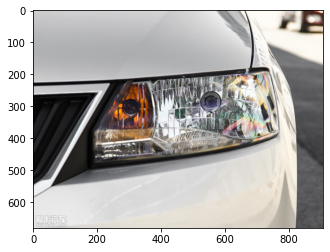

In [2]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/Car-Parts/6/0a0a817b86cfe1.jpg', 'r')

imshow(np.asarray(pil_im))

## Modelado de la red

Despues de comprobar que se puede acceder a los archivos, empezamos a crear los *data sources* para la red. Reescalaremos las imagenes a un tamaño de 150 x 150 para lograr 2 objetivos: que todas las imágenes sean del mismo tamaño y para que durante todo el proceso el valor no sea decimal; siempre será un número entero. Haremos tamaños de *batch* de 32 porque consideramos que es un valor aceptable. 

In [3]:
import tensorflow as tf

image_size = (150,150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Car-Parts",
    validation_split=0.2,
    subset="training",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/Car-Parts",
    validation_split=0.2,
    subset="validation",
    seed=1234,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical' 
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 802 files belonging to 8 classes.
Using 642 files for training.
Found 802 files belonging to 8 classes.
Using 160 files for validation.


Después hacemos el modelo de la red neuronal. Aquí haremos un reescalado de los valores para que estén comprendidos entre -1 y 1. Estó hará que, para la función de activación que usamos, sea más eficiente. Posteriormente, añadimos una red convolutiva usando un *kernel* de 3 x 3. Esto sirve para buscar distintos patrones en las imágenes que nos ayudarán a diferenciar entre las distintas partes de los coches. La siguiente herramienta que usamos se llama *Max Pooling*. Esta herramienta nos permite bajar drásticamente el número de datos a manipular, haciendo una generalización de un grupo de datos. En este caso el tamaño del grupo es de 2 x 2. El *Dropout* se usa para que la red no use el mismo camino todas las veces. Lo que hace esta herramienta es desactivar un porcentaje de las neuronas (dado por el parámetro) de forma aleatoria. Por ejemplo, si pones 0.25, se desactivarán un 25% de las neuronas para cada iteración del entrenamiento. La última herramienta es el *Dense*. Esto es simplemente una capa de la red que está *fully connected*.

La función de activación que usamos en la mayor parte de la red es la "relu". Esta función se mantiene en 0 para los números negativos y a medida que suben los números positivos, la función se mantiene. Por ejemplo: si el valor es 4, el resultado será 4 también. Al final usamos la función softmax porque nos ayuda a visualizar la probabilidad de que una imagen pertenezca a cada clase. Esto se debe a que los valores que devuelve estarán comprendidos entre 0 y 1, siendo 0 que no puede pertenecer a esa clase y 1 que está completamente seguro de que pertenece a dicha clase. 

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1,
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

Aquí empezamos a entrenar la neurona con los *datasets* de entrenamiento que habíamos hecho anteriormente. Utilizaremos el *early stopping* para parar en cuanto la mejora sea muy baja y así evitamos el *overfitting*. En este caso, paramos cuando hayan 5 valores de *accuracy* que sean muy similares. El overfitting es un caso bastante común que se da al entrenar neuronas. Esta situación ocurre cuando el *val_accuracy* baja mucho comparado con el *acuraccy* de entrenamiento. Esto se debe a que la neurona está memorizando en vez de aprender las diferencias. El early stopping evita esta situación porque para el entrenamiento cuando empieza a haber poca mejora.

In [5]:
epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, 
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
 6/21 [=======>......................] - ETA: 22s - loss: 3.4171 - accuracy: 0.1875

KeyboardInterrupt: ignored

## Evaluación de resultados

Una vez que la red se ha entrenado, haremos un gráfico para poder ver los resultados anteriores de una manera más sencilla. Estos valores indican la precisión del conjunto de entrenamiento, la precisión del conjunto de validación y la función de pérdida. 
Como podemos observar, la precisión de la red con el conjunto de entrenamiento es casi impoluto, llegando a más del **99% de los aciertos**. El conjunto de validación es más bajo, pero por solo un poco. Esto es lo normal e indica un buen uso de la red. La función de pérdida es descendente durante todo el transcurso del entrenamiento, que es algo que también indica un buen uso de la red.

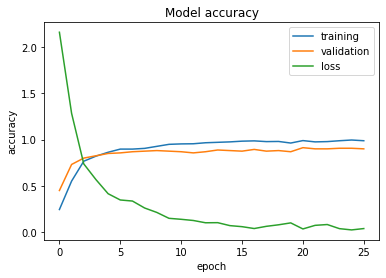

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

Ahora procedemos a hacer una matriz de confusión. Esta matriz nos permite ver donde se equivocó nuestra red y con que frecuencia aparecieron estos errores. Las filas representan cuantas instancias hay de cada clase y las columnas el valor que predijo la red neuronal. Por tanto, podemos ver que la mayor confusión que tuvo la red fue con la luz antinieblas y el faro trasero. Este es un fallo predecible porque estos dos son muy parecidos.

              precision    recall  f1-score   support

           0     0.9500    0.9048    0.9268        21
           1     1.0000    0.9000    0.9474        20
           2     1.0000    1.0000    1.0000        22
           3     0.8182    0.8182    0.8182        22
           4     0.8947    0.8947    0.8947        19
           5     0.8500    0.8095    0.8293        21
           6     0.9444    1.0000    0.9714        17
           7     0.8571    1.0000    0.9231        18

    accuracy                         0.9125       160
   macro avg     0.9143    0.9159    0.9139       160
weighted avg     0.9143    0.9125    0.9122       160



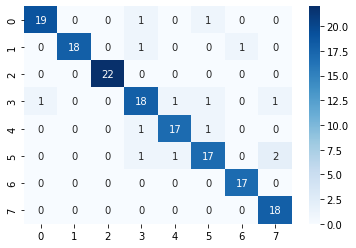

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))